Import training data:

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
sales_train = pd.read_csv('/content/gdrive/My Drive/Machine Learning/Project 1/sales_train.csv')
items = pd.read_csv('/content/gdrive/My Drive/Machine Learning/Project 1/items.csv')
categories = pd.read_csv('/content/gdrive/My Drive/Machine Learning/Project 1/item_categories.csv')

Merge sales data with category and item information:

In [4]:
sales_train = sales_train.merge(items, 'left', on = 'item_id')
sales_train = sales_train.merge(categories, 'left', on = 'item_category_id')

Add 'month' feature:

In [5]:
sales_train['date'] = pd.to_datetime(sales_train['date'],format='%d.%m.%Y')
sales_train['month'] = [sales_train.date[i].month for i in range(len(sales_train))]

Remove outlying data:

In [6]:
sales_train = sales_train[sales_train.item_price < 100000]
sales_train = sales_train[sales_train.item_price > 0]
sales_train = sales_train[sales_train.item_cnt_day < 999]

Add 'monthly sales performance' feature:

In [7]:
temp = sales_train.groupby(['date_block_num','shop_id',"item_id"]).agg({'item_cnt_day': ['sum']})
sales_train = sales_train.merge(temp, on = ["shop_id", "date_block_num","item_id"])

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


Add 'monthly price performance' feature

In [17]:
temp = sales_train.groupby(['date_block_num','shop_id',"item_id"]).agg({'item_price': ['sum']})
sales_train = sales_train.merge(temp, on = ["shop_id", "date_block_num","item_id"])
sales_train[('item_price', 'sum')] = sales_train[('item_price', 'sum')]/(sales_train[('item_cnt_day', 'sum')] + 0.01)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


Add 'category' feature:

In [35]:
sales_train['split'] = sales_train['item_category_name'].str.split('-')
sales_train['type'] = sales_train['split'].map(lambda x: x[0].strip())

sales_train = sales_train.drop(columns =["item_name", "item_category_name", "split"])

Encode categorical features:

In [36]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

sales_train['type'] = le.fit_transform(sales_train['type'])

Set target values:

In [37]:
target = sales_train["item_cnt_day"]

Standardize training data:

In [38]:
from sklearn.preprocessing import StandardScaler
X = sales_train.drop(columns =["item_cnt_day", "date"])
feature_names = list(X.columns)
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns = feature_names)
X

,date_block_num,shop_id,item_id,item_price,item_category_id,month,"(item_cnt_day, sum)","(item_price, sum)",type
0,-1.546210,1.602163,1.890609,0.062918,-0.175512,-1.483991,-0.214403,-0.011295,0.322209
1,-1.546210,-0.493114,-1.208866,0.004795,1.052506,-1.483991,-0.247974,8.762633,0.893684
2,-1.546210,-0.493114,-1.208866,0.004795,1.052506,-1.483991,-0.247974,8.762633,0.893684
3,-1.546210,-0.493114,-1.208550,0.475620,1.052506,-1.483991,-0.214403,0.023201,0.893684
4,-1.546210,-0.493114,-1.208392,0.121041,0.935552,-1.483991,-0.214403,-0.006436,0.893684
...,...,...,...,...,...,...,...,...,...
2935840,1.955866,-0.493114,-0.440875,-0.343942,0.877075,1.061101,-0.147260,-0.045206,0.893684
2935841,1.955866,-0.493114,-0.443405,-0.314881,0.877075,1.061101,-0.214403,-0.042873,0.893684
2935842,1.955866,-0.493114,-0.444828,-0.082389,0.877075,1.061101,-0.214403,-0.023440,0.893684
2935843,1.955866,-0.493114,-0.432969,-0.314881,0.877075,1.061101,-0.214403,-0.042873,0.893684


Generate  training and testing data:

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state = 30, test_size = 0.3, train_size = 0.7)

In [44]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math 

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = math.sqrt(mse)
print(rmse)

1.849324200890693


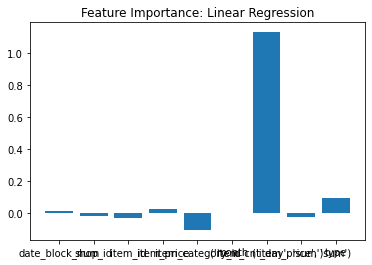

In [45]:
from matplotlib import pyplot
importance = regr.coef_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Linear Regression')
pyplot.show()

In [46]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC

# Decisiontree
dt = DecisionTreeClassifier(max_depth=3, random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred_dt), 2)
rmse = math.sqrt(mse)
print(rmse)

2.0952326839756963


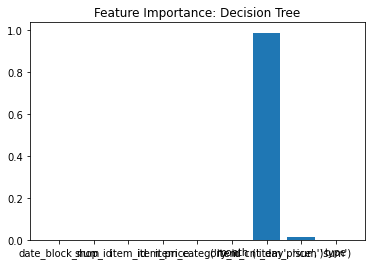

In [47]:
importance = dt.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Decision Tree')
pyplot.show()

In [48]:
# randomforestclassifier
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred_rf), 2)
rmse = math.sqrt(mse)
print(rmse)

2.130727575266252


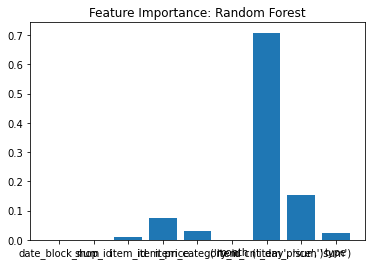

In [49]:
importance = rf.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Random Forest')
pyplot.show()

Add PCA:

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)

X = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2', 'pca3', 'pca4'])

Generate training and testing data:

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state = 30, test_size = 0.3, train_size = 0.7)

In [68]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math 

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = math.sqrt(mse)
print(rmse)

1.849324200890693


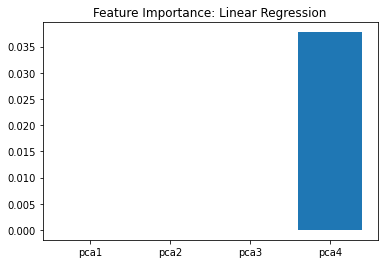

In [69]:
from matplotlib import pyplot
importance = regr.coef_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Linear Regression')
pyplot.show()

In [70]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC

# Decisiontree
dt = DecisionTreeClassifier(max_depth=3, random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred_dt), 2)
rmse = math.sqrt(mse)
print(rmse)

2.0952326839756963


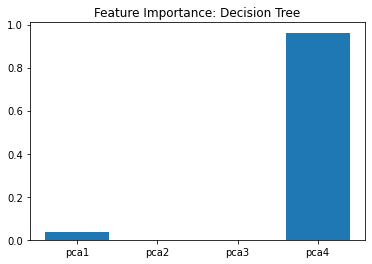

In [71]:
importance = dt.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Decision Tree')
pyplot.show()

In [72]:
# randomforestclassifier
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred_rf), 2)
rmse = math.sqrt(mse)
print(rmse)

2.1118712081942874


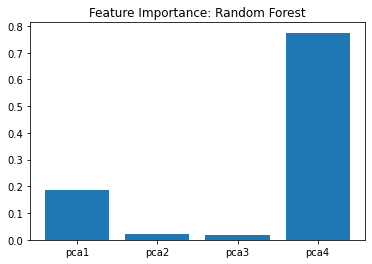

In [73]:
importance = rf.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Random Forest')
pyplot.show()

Add K-Means:

In [74]:
from sklearn.preprocessing import StandardScaler
X = sales_train.drop(columns =["item_cnt_day", "date"])
feature_names = list(X.columns)
#X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns = feature_names)
X

,date_block_num,shop_id,item_id,item_price,item_category_id,month,"(item_cnt_day, sum)","(item_price, sum)",type
0,0,59,22154,999.00,37,1,1.0,989.108911,11
1,0,25,2552,899.00,58,1,0.0,179800.000000,13
2,0,25,2552,899.00,58,1,0.0,179800.000000,13
3,0,25,2554,1709.05,58,1,1.0,1692.128713,13
4,0,25,2555,1099.00,56,1,1.0,1088.118812,13
...,...,...,...,...,...,...,...,...,...
2935840,33,25,7409,299.00,55,10,3.0,298.006645,13
2935841,33,25,7393,349.00,55,10,1.0,345.544554,13
2935842,33,25,7384,749.00,55,10,1.0,741.584158,13
2935843,33,25,7459,349.00,55,10,1.0,345.544554,13


In [75]:
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
X['kmeans'] = kmeans.labels_
X

,date_block_num,shop_id,item_id,item_price,item_category_id,month,"(item_cnt_day, sum)","(item_price, sum)",type,kmeans
0,0,59,22154,999.00,37,1,1.0,989.108911,11,4
1,0,25,2552,899.00,58,1,0.0,179800.000000,13,2
2,0,25,2552,899.00,58,1,0.0,179800.000000,13,2
3,0,25,2554,1709.05,58,1,1.0,1692.128713,13,0
4,0,25,2555,1099.00,56,1,1.0,1088.118812,13,0
...,...,...,...,...,...,...,...,...,...,...
2935840,33,25,7409,299.00,55,10,3.0,298.006645,13,0
2935841,33,25,7393,349.00,55,10,1.0,345.544554,13,0
2935842,33,25,7384,749.00,55,10,1.0,741.584158,13,0
2935843,33,25,7459,349.00,55,10,1.0,345.544554,13,0


Generate training and testing data:

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state = 30, test_size = 0.3, train_size = 0.7)

In [78]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math 

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = math.sqrt(mse)
print(rmse)

1.849324200890693


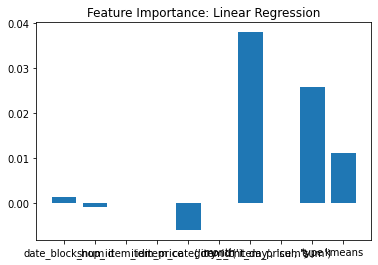

In [79]:
from matplotlib import pyplot
importance = regr.coef_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Linear Regression')
pyplot.show()

In [80]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC

# Decisiontree
dt = DecisionTreeClassifier(max_depth=3, random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred_dt), 2)
rmse = math.sqrt(mse)
print(rmse)

2.0952326839756963


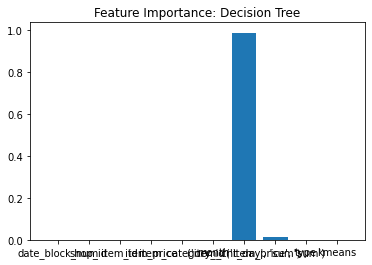

In [81]:
importance = dt.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Decision Tree')
pyplot.show()

In [82]:
# randomforestclassifier
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred_rf), 2)
rmse = math.sqrt(mse)
print(rmse)

2.130727575266252


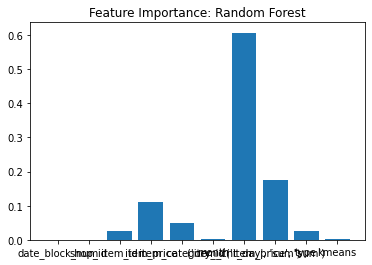

In [83]:
importance = rf.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks([x for x in range(len(importance))], X.columns)
pyplot.title('Feature Importance: Random Forest')
pyplot.show()